# Spatial KDE to Area of Prediction

This notebook integrates the outputs from notebook 01 and 02. In it, the Spatial KDE raster data for each block and economic activity is integrated to the Area of prediction generated through the morphology analysis generated for each block using Google buildings.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc
import rasterio as ro

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Data download/read and preprocessing

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((662437.93 2284457.02, 662421.516 228..."


### Spatial KDE directory

In [3]:
kde_dir = '../../data/processed/prediccion_uso_suelo/kde_output/'

### Area of prediction

In [4]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/tess_uso_test.geojson')
print(aop_gdf.shape)
aop_gdf.head(2)

(26735, 9)


,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,geometry
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,"POLYGON ((665861.85 2289152.881, 665861.743 22..."
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,"POLYGON ((665814.876 2289122.473, 665814.781 2..."


### Census data

In [5]:
poly_wkt = aoa_gdf.dissolve().geometry.to_wkt()[0]

In [6]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"


query_censo = f"""
SELECT 
"cvegeo_mza",
"pobtot",
"geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta y cargar los datos en un GeoDataFrame
block_gdf = aup.gdf_from_query(query_censo, geometry_col='geometry')
block_gdf = block_gdf.to_crs("EPSG:32613")

print(block_gdf.shape)
block_gdf.head()

(1826, 3)


,cvegeo_mza,pobtot,geometry
0,1403900011274035,368,"POLYGON ((666580.993 2287272.531, 666604.924 2..."
1,1403900011274036,384,"POLYGON ((666477.605 2287242.897, 666485.728 2..."
2,1403900010562026,34,"POLYGON ((666644.174 2288436.014, 666667.842 2..."
3,1403900010562027,58,"POLYGON ((666582.8 2288243.358, 666525.87 2288..."
4,1403900011043008,136,"POLYGON ((666790.839 2287931.492, 666776.664 2..."


## Data to Area of prediction

Population data

In [7]:
aop_data = aop_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], left_on='CVEGEO',
                        right_on='cvegeo_mza')
aop_data = aop_data.drop(columns=['cvegeo_mza'])
print(aop_data.shape)
aop_data.head(2)

(26735, 10)


,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,geometry,pobtot
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,"POLYGON ((665861.85 2289152.881, 665861.743 22...",277
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,"POLYGON ((665814.876 2289122.473, 665814.781 2...",277


In [8]:
aop_kde = gpd.GeoDataFrame()

for cvegeo in aop_gdf.CVEGEO.unique():
    kde_block = f'kde_mnz_{cvegeo}'
    aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo].copy()

    # iterate over every file
    for filename in os.listdir(kde_dir):

        # gather those corresponding to the specific block
        if filename.startswith(kde_block):

            # skip complementary raster files
            if filename.endswith('.aux.xml'):
                continue

            kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()

            # read file
            raster_kde = ro.open(kde_dir+filename)

            aop_tmp[kde_act] = aop_tmp.geometry.apply(lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)

    aop_kde = pd.concat([aop_kde, aop_tmp])

aop_kde = aop_kde.fillna(0)
print(aop_kde.shape)
aop_kde.head(5)

(26735, 16)


,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,geometry,cultural_recreativo,servicios,comercio,salud,educación,gobierno,industria
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,"POLYGON ((665861.85 2289152.881, 665861.743 22...",0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,"POLYGON ((665814.876 2289122.473, 665814.781 2...",0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,265,Habitacional,529.236347,75GRMHXW+7R25,141200001116A008,27.9500,190471.939851,0.002779,"POLYGON ((666324.394 2289554.605, 666324.194 2...",1.249131,0.0,0.0,0.0,0.0,0.0,0.0
3,266,Habitacional,1040.831070,75GRMHXX+J6V8,141200001116A008,18.0230,190471.939851,0.005464,"POLYGON ((666428.137 2289656.852, 666427.678 2...",2.347483,0.0,0.0,0.0,0.0,0.0,0.0
4,267,Habitacional,494.131042,75GRMHWV+JCCH,141200001116A008,33.1750,190471.939851,0.002594,"POLYGON ((665967.873 2289369.834, 665967.451 2...",0.000000,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

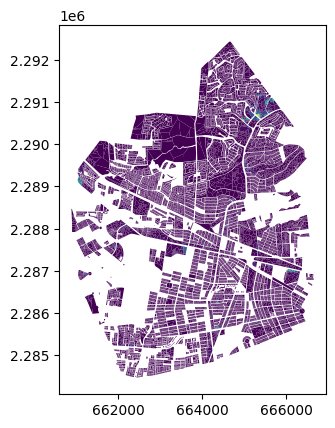

In [9]:
aop_kde.plot('servicios')

Merge data

In [10]:
aop_data = aop_data.merge(aop_kde[['fid','cultural_recreativo',
                                  'servicios','comercio','salud',
                                  'educación','gobierno','industria']])
print(aop_data.shape)
aop_data.head(2)

(26735, 17)


,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,geometry,pobtot,cultural_recreativo,servicios,comercio,salud,educación,gobierno,industria
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,"POLYGON ((665861.85 2289152.881, 665861.743 22...",277,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,"POLYGON ((665814.876 2289122.473, 665814.781 2...",277,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate land use and population percentages

In [11]:
# divide total population by area
aop_area = aop_data[['CVEGEO','area_m2']].groupby('CVEGEO').sum().reset_index().rename(columns={'area_m2':'area_m2_tot'})
aop_data = aop_data.merge(aop_area, on='CVEGEO')
aop_data['pobtot_relative'] = aop_data['pobtot'] * (aop_data['area_m2']/aop_data['area_m2_tot'])
aop_data.head(2)

,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,geometry,pobtot,cultural_recreativo,servicios,comercio,salud,educación,gobierno,industria,area_m2_tot,pobtot_relative
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,"POLYGON ((665861.85 2289152.881, 665861.743 22...",277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192072.147733,2.151825
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,"POLYGON ((665814.876 2289122.473, 665814.781 2...",277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192072.147733,0.277295


In [12]:
aop_data = aop_data.rename(columns={'pobtot_relative':'habitacional',
                                   'educación':'educacion'})

In [13]:
uso_list = ['habitacional','cultural_recreativo','servicios',
           'comercio','salud','educacion','gobierno',
           'industria']

In [14]:
aop_data['uso_tot'] = aop_data[uso_list].sum(axis=1)

In [15]:
for us in uso_list:
    aop_data['pct_'+us] = aop_data[us]/aop_data['uso_tot']

In [16]:
aop_data = aop_data.fillna(0)
aop_data.head(2)

,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,geometry,pobtot,...,habitacional,uso_tot,pct_habitacional,pct_cultural_recreativo,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,"POLYGON ((665861.85 2289152.881, 665861.743 22...",277,...,2.151825,2.151825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,"POLYGON ((665814.876 2289122.473, 665814.781 2...",277,...,0.277295,0.277295,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save data

In [17]:
aop_data.to_file('../../data/processed/prediccion_uso_suelo/tess_kde.geojson')